## 뉴스 요약 봇 만들기 

뉴스를 읽고 이를 요약하는 방법에는 추출적 요약, 추상적 요약이 있다. 

### 추출적 요약  
> 추출적 요약은 원문에서 문장들을 추출해서 요약하는 방식이다. 이 방법에서는 핵심 문장을 추출해 낼 수는 있어도 핵심 문장을 문법적으로 자연스럽게 이어지는 것이 힘들 수 있는데, 이를 위해서 전통적인 머신 러닝 방식에 속하는 텍스트 랭크와 같은 알고리즘을 사용한다.  
  
### 추상적 요약  
>추상적 요약은 원문으로부터 직접 추출해내는 것이 아니라 새로운 문장을 생성한다. 이 과정에서 원문에서 추출한 것이 아니기 때문에 원문에서 사용되지 않은 단어가 나타날 수 있다. 추상적 요약은 추출적 요약과 다르게 딥러닝 NLP, RNN으로 구현한다. 이는 인코더와 디코더의 구조로 구성된 딥러닝 아키텍처인 <strong>seq2seq</strong>으로 비교적 쉽게 구현이 가능하다.

## 라이브러리 및 데이터 준비

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [2]:
data.sample(10)

,headlines,text
94591,"Dhoni still best leader, Smith learning from h...",Speaking about Steve Smith taking over the cap...
34292,Need grievance cell for sexual offences in Bol...,"Talking about the issue of sexual harassment, ..."
53056,"7 killed, 23 injured in blast aimed at police ...",At least seven people were killed and 23 other...
25066,Make Chandigarh 'original capital' of Punjab: ...,Punjab CM Captain Amarinder Singh has asked Ho...
13886,Yes Bank appoints Korn Ferry to find Rana Kapo...,Yes Bank has appointed US-based advisory firm ...
75637,"Ab Ki Baar, BJP Sarkar, Amit Shah chants on Ka...",BJP National President Amit Shah said during h...
33287,"Trump slams WH press dinner, calls it an embar...",Slamming this year's White House Correspondent...
2444,"Will continue experimenting, taking risks as a...",Ranveer Singh has said that he will continue t...
36025,World is becoming more chaotic: Russian Presid...,Amid the ongoing tension between Russia and th...
40674,"Man, son arrested for possessing tiger skin in...",Police have arrested a 62-year-old man and his...


받은 데이터에서 원문인 text 열과 요약된 headlines 열을 사용한다.  
이를 위해서 간단하게 15개의 샘플 데이터를 추출해본다.

In [3]:
data = data[['text','headlines']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,text,headlines
79242,Delhi government has told Philip Morris and ot...,"Delhi govt tells Marlboro maker, others to rem..."
80604,At least 10 people were injured in Pamplona's ...,10 injured in bull run festival in Spain's Pam...
18197,Delhi Chief Minister Arvind Kejriwal on Saturd...,Delhi govt inaugurates drive to plant 5 lakh t...
26333,During his interaction with the women who are ...,Financial independence necessary to empower wo...
60754,Virat Kohli registered the joint-most internat...,Kohli records joint-most ducks by an India cap...
6508,Union Minister Sushma Swaraj on Wednesday asse...,Pakistan illegally occupying Indian territory ...
40303,Delhi Metro services between Dwarka Sector-21 ...,Delhi Metro services halted after staff fight ...
20108,US-based home-rental startup Airbnb has named ...,Airbnb adds ex-Pixar CFO as first-ever woman o...
73784,Danish police confirmed that a headless torso ...,Headless torso of missing journalist found
43279,"Former Indian cricketer Rahul Dravid, who amon...",Dravid files police complaint against Bengalur...


## 추상적 요약(seq2seq)

## 데이터 전처리

### 중복치와 결측치 제거 

In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


### 텍스트 정규화, 불용어 제거

텍스트 정규화는 자연어에서 쓰이는 'it is'의 축약어인 '"it's"와 같은 문장, 표현을 서로 다르게 연산하지 않도록 미리 딕셔너리형으로 사전을 구성한다.

텍스트 정규화를 위한 사전을 아래와 같이 구성한다.

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


자연어를 처리할 때 실질적으로 도움이 되지 않는 단어들이 존재한다.  
이를 <strong>불용어</strong>라고 하고 이 불용어를 제거하는 것이 자연어 처리의 성능을 높일 수 있다. 

In [7]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

자연어 처리에 적합한 데이터로 만들기 위한 전처리를 과정을 함수로 정의했다.

In [8]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [10]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [11]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [12]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

결측치가 없어진 것을 확인할 수 있다.

In [13]:
print(data.isnull().sum())

text         0
headlines    0
dtype: int64


In [14]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


## Train / Test data set 

데이터를 Train data와 Test data로 나눈다.  
이 과정에서 데이터를 시각화하여 어느한 쪽으로 치우친 데이터인지 확인하기 쉽게 한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


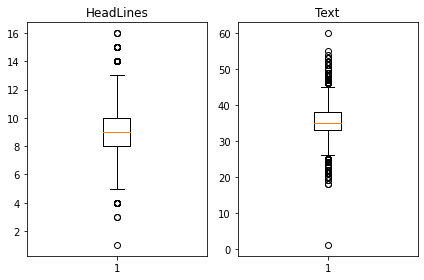

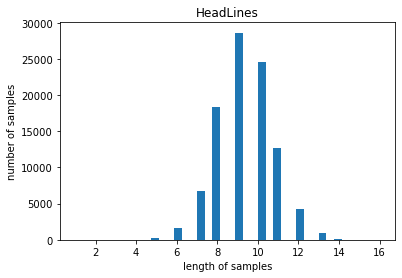

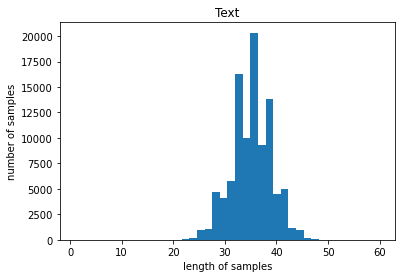

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('HeadLines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('HeadLines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 50
summary_max_len = 8

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


다음으로는 시작, 종료 토큰을 추가하여 문장의 시작과 끝을 모델이 파악하도록 한다.

In [19]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [20]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[  561 48519 25763 ...  4157 22433 95002]


In [22]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
n_of_val = int(len(encoder_input)*0.2)#학습, 테스트 데이터를 8:2로 설정한다.
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19672


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 정수 인코딩, 어휘 사전

당연하지만 컴퓨터는 자연어 문자를 그대로 받아들이지 않고 숫자로 받아들인다.  
즉 텍스트 데이터를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 숫자(정수)로 바꾸어줘야 한다. 이 말은 즉 각 고유 단어에 고유 정수를 부여하는, 맵핑이 필요한 것이다.  
이를 한 마디로 어휘 사전을 만든다고 한다.

In [25]:
src_tokenizer = Tokenizer() # 단어집합을 만들기 위한 토크나이저
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69651
등장 빈도가 6번 이하인 희귀 단어의 수: 47482
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22169
단어 집합에서 희귀 단어의 비율: 68.17131125181261
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4850453724449717


In [27]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2, 898, 2393, 662, 7795, 5984, 119, 19, 662, 2369, 119, 405, 119, 691, 240, 1467, 2, 2895, 6806, 3747, 4223, 7261, 615, 663, 791, 6544, 3404, 1693, 1062, 6, 4655, 1999, 1871, 3465, 784, 1213, 34, 6108], [2, 1545, 565, 1083, 1105, 1, 3819, 2405, 3082, 2859, 1240, 19, 194, 531, 3287, 452, 6988, 4690, 5089, 1105, 81, 452, 4690, 908, 137, 596, 1694, 34, 1546, 2405, 2859, 29, 424, 307, 372, 487, 1307], [8, 1042, 378, 741, 13, 127, 468, 1442, 460, 3773, 8, 88, 1, 751, 3536, 79, 160, 23, 12, 66, 115, 277, 391, 468, 98, 566, 485, 2578, 4267, 3604]]


In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30077
등장 빈도가 5번 이하인 희귀 단어의 수: 19628
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10449
단어 집합에서 희귀 단어의 비율: 65.25916813511986
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.627727879978831


등장 빈도가 5회 이하인 단어는 19628개로 어휘 사전에서 65% 가량을 차지하고있다.  
전체 원문에서 등장하는 빈도는 4.6%밖에 되지 않기 때문에 이 단어 들을 제거한다.

In [31]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 8, 369, 28, 1377], [1, 1634, 1845, 10, 53, 6, 315, 682, 8, 1704, 340], [1, 387, 511, 1769, 4, 25, 11, 62], [1, 79, 1348, 266, 157, 15], [1, 49, 104, 1770, 1050, 5, 1038, 1204]]
target
decoder  [[8, 369, 28, 1377, 2], [1634, 1845, 10, 53, 6, 315, 682, 8, 1704, 340, 2], [387, 511, 1769, 4, 25, 11, 62, 2], [79, 1348, 266, 157, 15, 2], [49, 104, 1770, 1050, 5, 1038, 1204, 2]]


In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 78678
훈련 레이블의 개수 : 78678
테스트 데이터의 개수 : 19670
테스트 레이블의 개수 : 19670


/home/aiffel-dj16/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


빈도수가 낮은 단어로만 구성되었던 샘플은 위 과정으로 비었거나 과도하게 작은 샘플이 되었을 수 있다. 이 때 길이가 0이 된 샘플들의 현상이 두드러지게 나타나기 때문에 이 인덱스를 drop_train과 drop_test에 담아 삭제한다.

## 패딩 

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 모델 설계 

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [35]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [36]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## 어텐션 매커니즘 

RNN 기반의 seq2seq 모델은 크게 두가지 문제가 있다.  
1. 하나의 고정된 크기의 벡터에 모든 정보를 압축하는 과정에서 정보 손실이 발생한다.  
2. RNN 특유의 고질적인 문제인 Gradient 소실이 발생한다.  
위 두 문제는 NLP에서 입력 문장이 길어지면 성능이 떨어지게 되고, 이를 보안하기 위해 어텐션 매커니즘이 사용된다.  
  
### 어텐션 이란  
>어텐션은 디코더에서 출력 단어를 예측하는 매 시점마다 인코더에서 전체 입력 문장을 참고한다. 하지만 전체 입력 문장을 계속 참고하는 것이 아닌 그 시점에서 예측해야되는 단어와 연관이 있는 입력 단어를 중점으로 더 집중(Attention)해서 참고하게 된다.

아직은 어텐션 매커니즘을 수행하는 어텐션 함수를 설계하는데에 무리이기 때문에, 이미 구현되어 있는 어텐션 함수를 다운로드한다.

In [37]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [38]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 학습 

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
308/308 [==============================] - 102s 331ms/step - loss: 5.1370 - val_loss: 4.7908
Epoch 2/50
308/308 [==============================] - 101s 327ms/step - loss: 4.5896 - val_loss: 4.3826
Epoch 3/50
308/308 [==============================] - 101s 327ms/step - loss: 4.2282 - val_loss: 4.1296
Epoch 4/50
308/308 [==============================] - 99s 323ms/step - loss: 3.9916 - val_loss: 3.9437
Epoch 5/50
308/308 [==============================] - 99s 323ms/step - loss: 3.8107 - val_loss: 3.8046
Epoch 6/50
308/308 [==============================] - 100s 326ms/step - loss: 3.6543 - val_loss: 3.6868
Epoch 7/50
308/308 [==============================] - 100s 326ms/step - loss: 3.5189 - val_loss: 3.5918
Epoch 8/50
308/308 [==============================] - 101s 330ms/step - loss: 3.4026 - val_loss: 3.5155
Epoch 9/50
308/308 [==============================] - 101s 329ms/step - loss: 3.3017 - val_loss: 3.4473
Epoch 10/50
308/308 [==============================] - 101s 329ms/

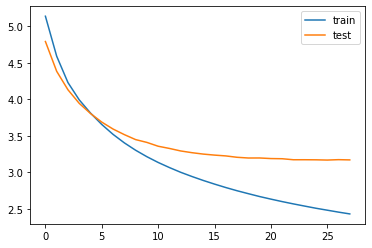

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

train 값과 test 값의 차가 점점 벌어진다.

## 인퍼런스 모델 

테스트 단계에서는 행렬로 변형했던 데이터를 실제 데이터(텍스트)로 복원해준다.

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [44]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시결과퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트 

In [45]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [46]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : instances currency india banking channels increased eight years according latest government data number reports increased data showed majority reports filed private indian banks 
실제 요약 : of fake currency has in years 
예측 요약 :  currency in india years rises to


원문 : jammu kashmir police started officers among stone catch real recent incident policemen mob pelting stones security forces caught two leading strong crowd used toy guns scare mob two stone taken police station 
실제 요약 : cops as stone to catch real 
예측 요약 :  police catch police catch


원문 : finance ministry asked public sector banks reduce government equity bid best corporate practices banks permission implement move market condition allows ministry said government stake help banks meet public norms market regulator sebi 
실제 요약 : state run banks to bring down govt to 
예측 요약 :  govt to sector banks


원문 : us based successfully conducted first ever site specific surgery times human hair surgery performed gold reducing proce

예측 요약 :  bsf chinese army to chinese


원문 : found message bottle travelled nearly kilometres greek island gaza via sea palestinian jihad al managed contact british couple placed bottle water july said felt letter travelled borders international waters without restrictions 
실제 요약 : finds message in from 
예측 요약 :  year old building in


원문 : china friday threatened impose import tariffs billion worth us goods retaliation tariffs imposed goods us tariffs would target us goods range chinese commerce ministry said imposing tariffs subject actions us 
실제 요약 : china threatens on bn us amid trade war 
예측 요약 :  china threatens to us


원문 : fleet north korean cargo ships laden coal turned back home port china issued official order april directing trading companies refuse comes china made initial announcement february banning imports north korean coal repeated missile tests despite international criticism 
실제 요약 : north korean ships head home after china rejects 
예측 요약 :  korea to south korean re

몇몇 요약은 비슷한 모습을 보이고 그렇지 못한 요약도 꽤 있어보인다. 이를 해결하는 방법으로는 <strong>어텐션의 조합을 개선</strong>하거나, <strong>빔 서치</strong>, <strong>사전 훈련이 되어있는 워드 임베딩</strong>, 인코더와 디코더의 구조를 새롭게 변경하는 <strong>트랜스포머</strong>와 같은 방안이 존재한다.

### 추출적 요약(summa)

Summa 패키지의 summarize메서드를 사용하면, 추출적 요약을 손 쉽게 사용할 수 있다.  
summarize 메서드에 들어가는 인자는 다음과 같다.  
><strong>text</strong> - 요약하고자 하는 텍스트.  
 <strong>ratio</strong> - float형태로 원본에서 뽑아낼 문장의 비율이다. 0과 1사이의 값이 들어간다.  
 <strong>words</strong> - 선택적 인수로 int를 넣거나 안넣어도 된다.ratio와 함께 사용한다면 ratio는 무시한다.  
 <strong>split</strong> - bool 타입을 넣어주거나 안넣어줘도 된다. True일 경우에는 list형태로 반환한다.

In [51]:
import requests
from summa.summarizer import summarize

In [108]:
text = data['text'][5]

In [109]:
text

'pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre'

In [110]:
print('Summary:')
print(summarize(text, ratio=0.01))

Summary:



테스트의 결과를 리스트로 받고싶다면 split 옵션을 True로 변경한다.

In [111]:
print('Summary:')
print(summarize(text, ratio=30, split=True))

Summary:
[]


또한 단어 수로 요약문의 크기를 정해줄 수 있다.

In [112]:
print('Summary:')
print(summarize(text, words=5))

Summary:



## 회고  
summa가 사용되지 않았다. 처음 text로써 data['text']로 그대로 넣어줬는데 , 넣어준 값이 object 타입이라서 사용되지 않았고, 따로 하나씩 추출해주니 String형태로 나와서 사용하려고 했는데, 오류는 따로 뜨지 않고 summary 값만 나오지 않아서 당장에 해결 방법은 찾지 못해서 아쉬웠다. 추상적 요약은 상당히 흥미로웠다. 굉장히 근접한 요약을 이끌어내지는 못했지만, 오히려 모델에서 새로운 표현을 한다는 것이 놀라웠다. 다시 다듬어야 할 프로젝트지만, 굉장히 흥미로운 프로젝트였다.